In [1]:
!apt install tree -q

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 87 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (138 kB/s)

78Selecting previously unselected package tree.
(Reading database ... 129184 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8Unpacking tree (2.0.2-1) ...
7Progress: [ 40%] [#######################...................................] 8Setting up tree (2.0.2-1) ...
7Progress: [ 60%] [##################################........................] 87Progress: [ 80

In [2]:
# list of all annotated faces cropped from dataset
!tree --filelimit 10  /kaggle/input/2025-06-26-apscscl-instance-seg-yolo/2025-06-27-class_crops/class_crops/face

/kaggle/input/2025-06-26-apscscl-instance-seg-yolo/2025-06-27-class_crops/class_crops/face  [3527 entries exceeds filelimit, not opening dir]

0 directories, 0 files


In [3]:
def display(path):
    import cv2
    from matplotlib import pyplot as plt
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    
    plt.figure(figsize=(2, 2))  # Increase figure size
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

In [4]:
# lists all contents
# !ls /kaggle/input/2025-06-26-apscscl-instance-seg-yolo/2025-06-27-class_crops/class_crops/face

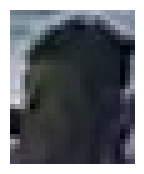

In [5]:
display("/kaggle/input/2025-06-26-apscscl-instance-seg-yolo/2025-06-27-class_crops/class_crops/face/yemiganuru_ch7_20250424090205_20250424090436_frame_90s_01992.jpg")

In [6]:
!pip install deepface -q
print("✅ DeepFace installation complete.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 2.7 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.5 MB/s eta 0:00:00
✅ DeepFace installation complete.


In [ ]:
import os
import shutil
# --- HIDE HARMLESS TENSORFLOW WARNINGS ---
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import matplotlib.pyplot as plt
import cv2
from deepface import DeepFace
import pandas as pd
import numpy as np
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)

# --- DEFINE ALL PATHS AND PARAMETERS ---

# 1. Path to the MAIN database of 3500+ faces to search through
SRC_DB_PATH = '/kaggle/input/2025-06-26-apscscl-instance-seg-yolo/2025-06-27-class_crops/class_crops/face/'

# 2. Path to the FOLDER containing your 12 area reference face folders
REFERENCE_FACES_PATH = '/kaggle/input/referencedata/faces/'

# 3. Writable location for the database (DeepFace needs to write a .pkl file here)
WRITABLE_DB_PATH = '/kaggle/working/face_db/'

# --- Parameters for the dashboard ---
TOP_N_MATCHES = 10
ARCFACE_THRESHOLD = 0.68 # Lower is more similar. Anything above this is likely not a match.

#------------------------------------------------------------------------------------
# PART 1: ONE-TIME DATABASE SETUP (This will take ~16 mins ONCE)
#------------------------------------------------------------------------------------

# Check if the processed database file already exists
pickle_file_path = os.path.join(WRITABLE_DB_PATH, 'ds_model_arcface_detector_opencv_aligned_normalization_base_expand_0.pkl')

if os.path.exists(pickle_file_path):
    print(f"✅ Pre-processed database found at '{WRITABLE_DB_PATH}'. Skipping setup.")
else:
    print("--- Starting One-Time Database Setup ---")
    
    # Copy the main database to a writable location if it's not already there
    if not os.path.exists(WRITABLE_DB_PATH):
        print(f"Copying main database from '{SRC_DB_PATH}' to '{WRITABLE_DB_PATH}'...")
        shutil.copytree(SRC_DB_PATH, WRITABLE_DB_PATH)
        print("Copy complete.")
    else:
        print(f"Writable database directory already exists at '{WRITABLE_DB_PATH}'.")
        
    # This is the crucial step that processes all 3500+ images and creates the .pkl file.
    print("Processing all faces in the main database to create embeddings.")
    print("This will take approximately 16 minutes. Please be patient...")
    # We run find() once to force the creation of the embeddings file.
    try:
        DeepFace.find(
            img_path=np.zeros([10, 10, 3]), # A dummy black image
            db_path=WRITABLE_DB_PATH,
            model_name='ArcFace',
            enforce_detection=False
        )
        print("✅✅ One-Time Database Setup Complete! All future searches will be fast.")
    except Exception as e:
        print(f"An error occurred during database setup: {e}")
        print("Cannot proceed without a processed database.")
        # Stop execution if setup fails
        exit()

#------------------------------------------------------------------------------------
# PART 2: GENERATE THE SIMILARITY DASHBOARDS
#------------------------------------------------------------------------------------

print("\n\n--- Starting Dashboard Generation ---")

area_folders = sorted([d for d in os.listdir(REFERENCE_FACES_PATH) if os.path.isdir(os.path.join(REFERENCE_FACES_PATH, d))])

# Loop through each area folder (Bapatla, Guduru, etc.)
for area in area_folders:
    print("="*80)
    print(f"      GENERATING DASHBOARD FOR: {area.upper()}")
    print("="*80)
    
    current_area_path = os.path.join(REFERENCE_FACES_PATH, area)
    ref_images = sorted(os.listdir(current_area_path))
    
    # Identify roles based on filenames
    people_to_process = []
    for img_name in ref_images:
        role = "Hamali"
        if '-incharge' in img_name:
            role = "Incharge"
        elif '-deo' in img_name:
            role = "DEO"
        
        people_to_process.append({
            'role': role,
            'filename': img_name,
            'path': os.path.join(current_area_path, img_name)
        })

    num_people = len(people_to_process)
    if num_people == 0:
        continue

    # Create a large plot for the entire area's dashboard
    fig, axs = plt.subplots(num_people, 1 + TOP_N_MATCHES, figsize=(22, num_people * 2.2))
    # If there's only one person, axs is not a 2D array, so we fix it
    if num_people == 1:
        axs = np.array([axs])

    # Loop through each person in the current area
    for i, person in enumerate(people_to_process):
        
        # --- Display the reference image in the first column ---
        ref_img = cv2.imread(person['path'])
        ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
        axs[i, 0].imshow(ref_img)
        axs[i, 0].set_title(f"{person['role']}\n{person['filename']}", fontsize=10)
        axs[i, 0].axis('off')

        try:
            # Find the top matches for this person
            df_list = DeepFace.find(
                img_path=person['path'],
                db_path=WRITABLE_DB_PATH,
                model_name='ArcFace',
                enforce_detection=False
            )

            # Filter the results by the distance threshold
            if df_list and not df_list[0].empty:
                df = df_list[0]
                good_matches_df = df[df['distance'] <= ARCFACE_THRESHOLD].head(TOP_N_MATCHES)
            else:
                good_matches_df = pd.DataFrame() # Empty dataframe

            # --- Display the top N matches in the other columns ---
            for j in range(TOP_N_MATCHES):
                ax = axs[i, j + 1]
                if j < len(good_matches_df):
                    match_path = good_matches_df.iloc[j]['identity']
                    distance = good_matches_df.iloc[j]['distance']
                    
                    match_img = cv2.imread(match_path)
                    match_img = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)
                    ax.imshow(match_img)
                    
                    # Convert distance to similarity percentage
                    similarity_percent = (1 - distance) * 100
                    
                    # Special title for the first 3 matches
                    if j < 3:
                        ax.set_title(f"Sim: {similarity_percent:.1f}%\n(Dist: {distance:.2f})", fontsize=9, color='green')
                    else:
                         ax.set_title(f"Dist: {distance:.2f}", fontsize=9)
                else:
                    # If there are no more matches, display a black box
                    ax.imshow(np.zeros((100, 100, 3), dtype=np.uint8))
                    ax.text(0.5, 0.5, 'No Match', color='white', ha='center', va='center')
                
                ax.axis('off')

        except Exception as e:
            print(f"Error processing {person['filename']}: {e}")

    plt.tight_layout(pad=0.5, h_pad=1.0)
    plt.show()